# Install

In [ ]:
# !pip install tensorflow==2.3.0
!pip install gym

# Network Scheduler

### Libraries

In [2]:
import numpy as np
import pandas as pd
import random
from collections import deque
import matplotlib.pyplot as plt

### Environment

#### Node

In [6]:
class Queue:
    def __init__(self, value=[]):
        self.items = deque(value)

    def put(self, data):
        self.items.append(data)

    def get(self):
        if not self.is_empty():
            return self.items.popleft()
        else:
            print("underflow")
            exit()

    def peek(self):
        if not self.is_empty():
            return self.items[0]
        else:
            print("underflow")
            exit()
            
    def getByIdx(self,index):
        try:
            return self.items[index]
        except IndexError:
            pass
            
    def iterator(self):
        list = []
        if not self.is_empty():
            for i in range(len(self.items)):
                list.append(self.getByIdx(i))
            return list
            
    def len(self):
        return len(self.items)

    def is_empty(self):
        return len(self.items) == 0
    
    def inc_dealy(self):
        if not self.is_empty():
            for i in range(len(self.items)):
                temp = self.items[i].copy()
                self.items[i]['delay'] = self.items[i]['delay'] + 1
                print(str(temp) + '가 ' + str(self.items[i]) + '로 딜레이 증가')

In [7]:
class Node:
    def __init__(self,input_num,output_num):
        self.input_num = input_num
        self.output_num = output_num
        self.input_port = []
        self.output_port = []
        for i in range(self.input_num):
            self.input_port.append(Queue())
        for i in range(self.output_num):
            self.output_port.append(Queue())
            
    def packet_reception(self,source,data,delay):
        if(data != 0):
            self.input_port[source].put({'data':data,'delay':delay})
            print('수신 : input_port['+str(source)+']'+ '에 추가 :' + str({'data':data,'delay':delay}))
        else:
            pass

    def packet_send(self,input_que,output_que):
        if(self.input_port[input_que].is_empty() != True):
            get = self.input_port[input_que].get()
            self.output_port[output_que].put(get)
            print('송신 : output_port['+str(output_que)+']'+ '에 추가 :' +str(get))
            return get
        else:
            pass
        
    def print_port(self):
        for i in range(len(self.input_port)):
            print('input_port['+str(i)+']',self.input_port[i])
        print('---------------------------------------------')
        for i in range(len(self.output_port)):
            print('output_port['+str(i)+']',self.output_port[i])
        print('---------------------------------------------')

#### Topology3 환경

In [8]:
class Topology3_RL():
    def __init__(self):
        #input 2, output1인 노드
        self.Node = Node(2,1)
        
        self.index = 0
        
        #data source (시나리오 생성)
        self.source0 = [1,0]
        self.source1 = [0,1]
        self.source2 = [1,0]
        self.delay_source0 = 1 #T
        self.delay_source1 = 7 #7T
        self.delay_source2 = 3 #3T
        
        #stae 정의
        #첫 번째 패킷의 현재까지의 지연 시간
        self.queue0_first_packet_delay = -1
        self.queue1_first_packet_delay = -1
        
        #큐 길이
        self.queue0_length = -1
        self.queue1_length = -1
        
        #큐에 있는 패킷들의 최대 추정 지연 시간 (현재 까지의 지연시간(이미 지나온 지연시간) + 패킷 큐의 순서(수신할 때의 큐의 순서))
        self.queue0_max_estimated_delay = -1
        self.queue1_max_estimated_delay = -1


    def step(self, a):
        #input_port의 큐 두 개안에 있던 데이터가 송신되지 않으면 delay가 늘어야함
        self.Node.input_port[0].inc_dealy()
        self.Node.input_port[1].inc_dealy()
        
        #시작 Time Step이 0 일때
        if(self.index == 0):
            self.Node.packet_reception(0,self.source1[self.index],self.delay_source1)
            self.Node.packet_reception(0,self.source0[self.index],self.delay_source0)
            self.Node.packet_reception(1,self.source2[self.index],self.delay_source2)
        else:
            self.delay_source0 += 1
            self.delay_source1 += 1
            self.delay_source2 += 1
            #수신은 공통 (소스1과 0이 동시에 있을 경우 지연시간이 긴 소스1 먼저 수신 받음)
            try:
                self.Node.packet_reception(0,self.source1[self.index],self.delay_source1)
                self.Node.packet_reception(0,self.source0[self.index],self.delay_source0)
                self.Node.packet_reception(1,self.source2[self.index],self.delay_source2)
            except IndexError:
                pass
            
        
        #송신
        #0번 액션: 0번 큐 선택, 1번 액션: 1번 큐 선택
        if a==0:
            condition, estimated_delay_of_the_transmitted_packet = self.send_queue0()
        elif a==1:
            condition, estimated_delay_of_the_transmitted_packet = self.send_queue1()

        # reward 는 최대 추정 지연시간
        # if(condition != -1):
        #     max = 0
        #     if(self.Node.input_port[0].is_empty() != True):
        #         for i in range(self.queue0_length):
        #             data = self.Node.input_port[0].getByIdx(i)
        #             temp = 0
        #             if(data['delay'][0] == 'T'):
        #                 temp = 1 + i
        #             else:
        #                 temp = int(data['delay'][0]) + i
                    
        #             if(temp > max):
        #                 max = temp
        #     else:
        #         max = 0
                
        #     if(self.Node.input_port[1].is_empty() != True):    
        #         for i in range(self.queue1_length):
        #             data = self.Node.input_port[1].getByIdx(i)
        #             temp = 0
        #             if(data['delay'][0] == 'T'):
        #                 temp = 1 + i
        #             else:
        #                 temp = int(data['delay'][0]) + i
                    
        #             if(temp > max):
        #                 max = temp     
        #     else:
        #         max = max
                
        #     if(estimated_delay_of_the_transmitted_packet > max):
        #         reward = estimated_delay_of_the_transmitted_packet
        #     else:
        #         reward = max
        # else:
        #     reward = -1

        # reward 는 (지금 전송한 패킷의 추정 지연시간 - 남아있는 패킷의 추정 지연시간)
        if(condition != -1):
            if(self.Node.input_port[0].is_empty() and self.Node.input_port[1].is_empty()):
                reward = estimated_delay_of_the_transmitted_packet
            else:
                max = 0
                if(self.Node.input_port[0].is_empty() != True):
                    for i in range(self.queue0_length):
                        data = self.Node.input_port[0].getByIdx(i)
                        temp = data['delay'] + i
                        if(temp > max):
                            max = temp
                else:
                    max = 0
                    
                if(self.Node.input_port[1].is_empty() != True):    
                    for i in range(self.queue1_length):
                        data = self.Node.input_port[1].getByIdx(i)
                        temp = data['delay'] + i
                        if(temp > max):
                            max = temp    
                else:
                    max = max
                    
                reward = estimated_delay_of_the_transmitted_packet - max
        else:
            reward = -1
        
        done = self.is_done()
        
        #index 증가
        self.index = self.index + 1
        
        print((self.queue0_first_packet_delay,self.queue1_first_packet_delay,self.queue0_length,self.queue1_length,self.queue0_max_estimated_delay,self.queue1_max_estimated_delay), reward, done)
        return (self.queue0_first_packet_delay,self.queue1_first_packet_delay,self.queue0_length,self.queue1_length,self.queue0_max_estimated_delay,self.queue1_max_estimated_delay), reward, done

    def send_queue0(self):
        if(self.Node.input_port[0].is_empty() != True):
            data = self.Node.packet_send(0,0)
            condition = 0
            estimated_delay_of_the_transmitted_packet = data['delay'] 
        else:
            condition = -1
            estimated_delay_of_the_transmitted_packet = 0
        
        #action 후의 state 변화
        #첫 번째 패킷의 현재까지의 지연 시간
        if(self.Node.input_port[0].is_empty() != True):
            self.queue0_first_packet_delay = self.Node.input_port[0].peek()['delay']
        else:
            self.queue0_first_packet_delay = 0
        
        if(self.Node.input_port[1].is_empty() != True):
            self.queue1_first_packet_delay = self.Node.input_port[1].peek()['delay']
        else:
            self.queue1_first_packet_delay = 0
        
        #큐 길이
        self.queue0_length = self.Node.input_port[0].len()
        self.queue1_length = self.Node.input_port[1].len()
        
        #큐에 있는 패킷들의 최대 추정 지연 시간 (현재 까지의 지연시간(이미 지나온 지연시간) + 패킷 큐의 순서(수신할 때의 큐의 순서))
        max = 0
        if(self.Node.input_port[0].is_empty() != True):
            for i in range(self.queue0_length):
                data = self.Node.input_port[0].getByIdx(i)
                temp = data['delay'] + i  
                if(temp > max):
                    max = temp
            self.queue0_max_estimated_delay = max
        else:
            self.queue0_max_estimated_delay = 0
           
        max = 0
        if(self.Node.input_port[1].is_empty() != True):    
            for i in range(self.queue1_length):
                data = self.Node.input_port[1].getByIdx(i)
                temp = data['delay'] + i         
                if(temp > max):
                    max = temp
            self.queue1_max_estimated_delay = max
        else:
            self.queue1_max_estimated_delay = 0
            
        return (condition,estimated_delay_of_the_transmitted_packet)

    def send_queue1(self):
        if(self.Node.input_port[1].is_empty() != True):
            data = self.Node.packet_send(1,0)
            condition = 0
            estimated_delay_of_the_transmitted_packet = data['delay']
        else:
            condition = -1
            estimated_delay_of_the_transmitted_packet = 0
        
        
        #action 후의 state 변화
        #첫 번째 패킷의 현재까지의 지연 시간
        if(self.Node.input_port[0].is_empty() != True):
            self.queue0_first_packet_delay = self.Node.input_port[0].peek()['delay']
        else:
            self.queue0_first_packet_delay = 0
        
        if(self.Node.input_port[1].is_empty() != True):
            self.queue1_first_packet_delay = self.Node.input_port[1].peek()['delay']
        else:
            self.queue1_first_packet_delay = 0
        
        #큐 길이
        self.queue0_length = self.Node.input_port[0].len()
        self.queue1_length = self.Node.input_port[1].len()
        
        #큐에 있는 패킷들의 최대 추정 지연 시간 (현재 까지의 지연시간(이미 지나온 지연시간) + 패킷 큐의 순서(수신할 때의 큐의 순서))      
        max = 0
        if(self.Node.input_port[0].is_empty() != True):
            for i in range(self.queue0_length):
                data = self.Node.input_port[0].getByIdx(i)
                temp = data['delay'] + i  
                if(temp > max):
                    max = temp
            self.queue0_max_estimated_delay = max
        else:
            self.queue0_max_estimated_delay = 0
           
        max = 0
        if(self.Node.input_port[1].is_empty() != True):    
            for i in range(self.queue1_length):
                data = self.Node.input_port[1].getByIdx(i)
                temp = data['delay'] + i         
                if(temp > max):
                    max = temp
            self.queue1_max_estimated_delay = max
        else:
            self.queue1_max_estimated_delay = 0
            
        return (condition,estimated_delay_of_the_transmitted_packet)

    def is_done(self):
        #시나리오의 패킷의 갯수가 3개이기 때문에
        if (self.Node.output_port[0].len() == 3):
            return True
        else:
            return False
      
    def reset(self):
        #input 2, output1인 노드
        self.Node = Node(2,1)
        
        self.index = 0
        
        #data source (시나리오 생성)
        self.source0 = [1,0]
        self.source1 = [0,1]
        self.source2 = [1,0]
        self.delay_source0 = 1 #T
        self.delay_source1 = 7 #7T
        self.delay_source2 = 3 #3T
        print('시나리오 ------------------ ')
        print(self.source0)
        print(self.source1)
        print(self.source2)
        print(' ------------------------- ')
        
        #stae 정의
        #첫 번째 패킷의 현재까지의 지연 시간
        self.queue0_first_packet_delay = -1
        self.queue1_first_packet_delay = -1
        
        #큐 길이
        self.queue0_length = -1
        self.queue1_length = -1
        
        #큐에 있는 패킷들의 최대 추정 지연 시간 (현재 까지의 지연시간(이미 지나온 지연시간) + 패킷 큐의 순서(수신할 때의 큐의 순서))
        self.queue0_max_estimated_delay = -1
        self.queue1_max_estimated_delay = -1
        
        return (self.queue0_first_packet_delay,self.queue1_first_packet_delay,self.queue0_length,self.queue1_length,self.queue0_max_estimated_delay,self.queue1_max_estimated_delay)


### Q-Learning

##### 바닥부터 배우는 강화학습 책 기반

시나리오 ------------------ 
[1, 0]
[0, 1]
[1, 0]
 ------------------------- 
수신 : input_port[0]에 추가 :{'data': 1, 'delay': 1}
수신 : input_port[1]에 추가 :{'data': 1, 'delay': 3}
송신 : output_port[0]에 추가 :{'data': 1, 'delay': 3}
(1, 0, 1, 0, 1, 0) 2 False
{'data': 1, 'delay': 1}가 {'data': 1, 'delay': 2}로 딜레이 증가
수신 : input_port[0]에 추가 :{'data': 1, 'delay': 8}
(2, 0, 2, 0, 9, 0) -1 False
{'data': 1, 'delay': 2}가 {'data': 1, 'delay': 3}로 딜레이 증가
{'data': 1, 'delay': 8}가 {'data': 1, 'delay': 9}로 딜레이 증가
송신 : output_port[0]에 추가 :{'data': 1, 'delay': 3}
(9, 0, 1, 0, 9, 0) -6 False
{'data': 1, 'delay': 9}가 {'data': 1, 'delay': 10}로 딜레이 증가
(10, 0, 1, 0, 10, 0) -1 False
{'data': 1, 'delay': 10}가 {'data': 1, 'delay': 11}로 딜레이 증가
송신 : output_port[0]에 추가 :{'data': 1, 'delay': 11}
(0, 0, 0, 0, 0, 0) 11 True
시나리오 ------------------ 
[1, 0]
[0, 1]
[1, 0]
 ------------------------- 
수신 : input_port[0]에 추가 :{'data': 1, 'delay': 1}
수신 : input_port[1]에 추가 :{'data': 1, 'delay': 3}
송신 : output_port[0]에 추가 :{'data': 1,

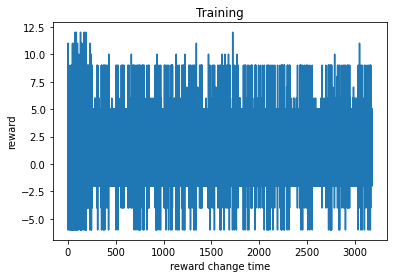

           0         1                     state
1   7.000000  4.992098  (-1, -1, -1, -1, -1, -1)
2   2.999045 -1.598184        (1, 0, 1, 0, 1, 0)
3  -2.475459 -1.116227        (2, 0, 2, 0, 9, 0)
4   7.941089  1.632616        (9, 0, 1, 0, 9, 0)
5   7.548083  0.255512      (10, 0, 1, 0, 10, 0)
6   0.000000  0.000000        (0, 0, 0, 0, 0, 0)
7   9.000000  4.999795        (0, 3, 0, 1, 0, 3)
8   4.994045  5.000000        (0, 4, 0, 1, 0, 4)
9   0.436994  5.999140        (0, 5, 0, 1, 0, 5)
10  9.000000  4.001514        (8, 0, 1, 0, 8, 0)
11  5.622708 -0.271000      (11, 0, 1, 0, 11, 0)
12  0.000000  0.000000      (12, 0, 1, 0, 12, 0)
13 -0.186296 -0.795613       (3, 0, 2, 0, 10, 0)
14 -1.322076 -0.461810       (4, 0, 2, 0, 11, 0)
15 -0.600000 -0.343900       (5, 0, 2, 0, 12, 0)
16 -0.110000  3.279913        (0, 6, 0, 1, 0, 6)
17  0.000000  1.520000        (0, 7, 0, 1, 0, 7)
18  0.000000  0.000000       (6, 0, 2, 0, 13, 0)


In [5]:
class QAgent():
    def __init__(self):
        #self.q_table = np.zeros((15,15,15,15,20,20,2)) # 마찬가지로 Q 테이블을 0으로 초기화
        self.state = {} #key는 index이름(정수로 설정) value는 state 리스트 (정의한 6개 state 구성요소들을 하나의 정수(하나의 state)로 표현하여 key로 사용)
        self.q_table = pd.DataFrame(index=(self.state.keys()), columns =[0,1]) #columns : action0,1
        self.eps = 0.9

    def q_table_state(self,s):
        key=0 #전역변수 생성
        s_now = -1 #이번 state의 index 표시할 변수
        
        for key, value in list(self.state.items()): #지금 state가 원래 있었던 state인지 딕셔너리에서 검사
            if s == value:#딕셔너리에 있었다면 (s는 지금 state이고 value는 딕셔너리에 저장되어 있던 state)
                s_now = key #이번 state인덱스는 딕셔너리에 있던 key(index번호), for문이 끝날때까지 딕셔너리에 동일한 state가 없었다면 key는 마지막 index로 갈 것
        if s_now == -1: #for문 끝나고 같은 state가 없었다면 s_now는 초기값인 -1일 것
            self.state[key+1]=s #새로운 딕셔너리 생성(key는 마지막 index+1)
            s_now = key+1
            self.q_table.loc[s_now] = [0,0]#0으로 초기화 (dataframe에도 새로 생성)
        return s_now

    def select_action(self, s):
        # eps-greedy로 액션을 선택해준다
        x,y,z,b,c,d = s
        
        s_now = self.q_table_state(s)
                
        coin = random.random()
        if coin < self.eps:
            action = random.randint(0,1)
        else:
            action_val = self.q_table.loc[[s_now], :]
            action = np.argmax(np.array(action_val))
        return action

    def update_table(self, transition):
        s, a, r, s_prime = transition
        x,y,z,b,c,d = s
        next_x, next_y, next_z, next_b, next_c, next_d = s_prime
        
        s_now = self.q_table_state(s)
        s_prime_now = self.q_table_state(s_prime)
        
        a_prime = self.select_action(s_prime) # S'에서 선택할 액션 (실제로 취한 액션이 아님)
        # Q러닝 업데이트 식을 이용 
        self.q_table.loc[[s_now], self.q_table.columns[a]]= self.q_table.loc[[s_now], self.q_table.columns[a]] + 0.1 * (r + np.amax(np.array(self.q_table.loc[[s_prime_now], :])) - self.q_table.loc[[s_now], self.q_table.columns[a]])

    def anneal_eps(self):
        self.eps -= 0.01  # Q러닝에선 epsilon 이 좀더 천천히 줄어 들도록 함.
        self.eps = max(self.eps, 0.2)      

def main():
    env = Topology3_RL()
    agent = QAgent()
    
    r_list = []
    
    for n_epi in range(1000):
        done = False
        step = 0
        
        s = env.reset()
        while not done:
            a = agent.select_action(s)
            s_prime, r, done = env.step(a)
            
            r_list.append(r)
    
            agent.update_table((s,a,r,s_prime))
            s = s_prime
            
            step += 1
            if((env.is_done()!=True) and (step == 6)):
                print('강제 종료')
                break
            
        agent.anneal_eps()
        
    x = range(len(r_list))
    plt.plot(x,r_list)
    plt.xlabel('reward change time')
    plt.ylabel('reward')
    plt.title('Training')
    plt.show()

    agent.q_table['state'] = list(agent.state.values())
    print(agent.q_table)

if __name__ == '__main__':
    main()

##### 예제 코드

In [ ]:
import random
import numpy as np

class GridWorld():
    def __init__(self):
        self.x=0
        self.y=0
    
    def step(self, a):
        # 0번 액션: 왼쪽, 1번 액션: 위, 2번 액션: 오른쪽, 3번 액션: 아래쪽
        if a==0:
            self.move_left()
        elif a==1:
            self.move_up()
        elif a==2:
            self.move_right()
        elif a==3:
            self.move_down()

        reward = -1 # 보상은 항상 -1로 고정
        done = self.is_done()
        return (self.x, self.y), reward, done

    def move_left(self):
        if self.y==0:
            pass
        elif self.y==3 and self.x in [0,1,2]:
            pass
        elif self.y==5 and self.x in [2,3,4]:
            pass
        else:
            self.y -= 1

    def move_right(self):
        if self.y==1 and self.x in [0,1,2]:
            pass
        elif self.y==3 and self.x in [2,3,4]:
            pass
        elif self.y==6:
            pass
        else:
            self.y += 1
      
    def move_up(self):
        if self.x==0:
            pass
        elif self.x==3 and self.y==2:
            pass
        else:
            self.x -= 1

    def move_down(self):
        if self.x==4:
            pass
        elif self.x==1 and self.y==4:
            pass
        else:
            self.x+=1

    def is_done(self):
        if self.x==4 and self.y==6:
            return True
        else:
            return False
      
    def reset(self):
        self.x = 0
        self.y = 0
        return (self.x, self.y)

class QAgent():
    def __init__(self):
        self.q_table = np.zeros((5, 7, 4)) # 마찬가지로 Q 테이블을 0으로 초기화
        self.eps = 0.9

    def select_action(self, s):
        # eps-greedy로 액션을 선택해준다
        x, y = s
        coin = random.random()
        if coin < self.eps:
            action = random.randint(0,3)
        else:
            action_val = self.q_table[x,y,:]
            action = np.argmax(action_val)
        return action

    def update_table(self, transition):
        s, a, r, s_prime = transition
        x,y = s
        next_x, next_y = s_prime
        a_prime = self.select_action(s_prime) # S'에서 선택할 액션 (실제로 취한 액션이 아님)
        # Q러닝 업데이트 식을 이용 
        self.q_table[x,y,a] = self.q_table[x,y,a] + 0.1 * (r + np.amax(self.q_table[next_x,next_y,:]) - self.q_table[x,y,a])

    def anneal_eps(self):
        self.eps -= 0.01  # Q러닝에선 epsilon 이 좀더 천천히 줄어 들도록 함.
        self.eps = max(self.eps, 0.2) 

    def show_table(self):
        q_lst = self.q_table.tolist()
        data = np.zeros((5,7))
        for row_idx in range(len(q_lst)):
            row = q_lst[row_idx]
            for col_idx in range(len(row)):
                col = row[col_idx]
                action = np.argmax(col)
                data[row_idx, col_idx] = action
        print(data)
      

def main():
    env = GridWorld()
    agent = QAgent()
    r_list = []
    
    for n_epi in range(1000):
        done = False

        s = env.reset()
        while not done:
            a = agent.select_action(s)
            s_prime, r, done = env.step(a)
            r_list.append(r)
            agent.update_table((s,a,r,s_prime))
            s = s_prime
        agent.anneal_eps()

    agent.show_table()
    x = range(len(r_list))
    plt.plot(x,r_list)
    plt.xlabel('reward change time')
    plt.ylabel('reward')
    plt.title('Training')
    plt.show()
    print(agent.q_table.ndim)
    print(agent.q_table)

if __name__ == '__main__':
    main()

### Topology3 DQN

시나리오 ------------------ 
[1, 0]
[0, 1]
[1, 0]
 ------------------------- 
eps :  1.0  coin :  0.9460712303439766
수신 : input_port[0]에 추가 :{'data': 1, 'delay': 1}
수신 : input_port[1]에 추가 :{'data': 1, 'delay': 3}
송신 : output_port[0]에 추가 :{'data': 1, 'delay': 3}
(1, 0, 1, 0, 1, 0) 2 False
eps :  1.0  coin :  0.7487325408481678
{'data': 1, 'delay': 1}가 {'data': 1, 'delay': 2}로 딜레이 증가
수신 : input_port[0]에 추가 :{'data': 1, 'delay': 8}
(2, 0, 2, 0, 9, 0) -1 False
eps :  1.0  coin :  0.8315955659518621
{'data': 1, 'delay': 2}가 {'data': 1, 'delay': 3}로 딜레이 증가
{'data': 1, 'delay': 8}가 {'data': 1, 'delay': 9}로 딜레이 증가
송신 : output_port[0]에 추가 :{'data': 1, 'delay': 3}
(9, 0, 1, 0, 9, 0) -6 False
eps :  1.0  coin :  0.288140201795547
{'data': 1, 'delay': 9}가 {'data': 1, 'delay': 10}로 딜레이 증가
(10, 0, 1, 0, 10, 0) -1 False
eps :  1.0  coin :  0.23201337912796005
{'data': 1, 'delay': 10}가 {'data': 1, 'delay': 11}로 딜레이 증가
송신 : output_port[0]에 추가 :{'data': 1, 'delay': 11}
(0, 0, 0, 0, 0, 0) 11 True
시나리오 ------

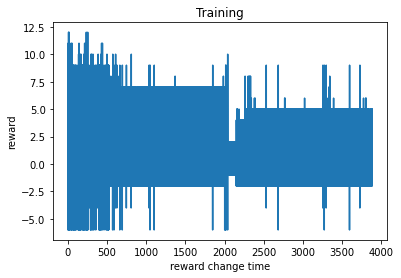

In [9]:
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 64

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(6, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        print('eps : ',epsilon, ' coin : ',coin)
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()
            
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def main():
    env = Topology3_RL()
    
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    r_list = []
    
    for n_epi in range(1000):
        #epsilon = max(0.01, 0.08 - 0.01*(n_epi/200))
        #epsilon = max(0.01, 1 - 0.05*((n_epi/200)**(5/2)))
        epsilon = max(0.01, 1 - 0.997*(n_epi/200))
        s = env.reset()
        done = False

        step = 0
        while not done:
            a = q.sample_action(torch.from_numpy(np.asarray(s)).float(), epsilon)      
            s_prime, r, done = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            r_list.append(r)
            
            score += r
            if done:
                break
            
            step += 1
            if((env.is_done()!=True) and (step == 6)):
                print('강제 종료')
                break
            
        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(n_epi, score/print_interval, memory.size(), epsilon*100))
            score = 0.0

    x = range(len(r_list))
    plt.plot(x,r_list)
    plt.xlabel('reward change time')
    plt.ylabel('reward')
    plt.title('Training')
    plt.show()
        
if __name__ == '__main__':
    main()

#### 예제 코드

In [13]:
import gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 32

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()
            
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def main():
    env = gym.make('CartPole-v1')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(10000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)      
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            score += r
            if done:
                break
            
        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                            n_epi, score/print_interval, memory.size(), epsilon*100))
            score = 0.0
    env.close()

if __name__ == '__main__':
    main()

n_episode :20, score : 16.4, n_buffer : 328, eps : 7.9%
n_episode :40, score : 16.1, n_buffer : 650, eps : 7.8%
n_episode :60, score : 16.4, n_buffer : 979, eps : 7.7%
n_episode :80, score : 17.2, n_buffer : 1324, eps : 7.6%
n_episode :100, score : 15.2, n_buffer : 1627, eps : 7.5%
n_episode :120, score : 16.1, n_buffer : 1949, eps : 7.4%
n_episode :140, score : 42.5, n_buffer : 2798, eps : 7.3%
n_episode :160, score : 49.5, n_buffer : 3788, eps : 7.2%
n_episode :180, score : 28.6, n_buffer : 4361, eps : 7.1%
n_episode :200, score : 24.4, n_buffer : 4848, eps : 7.0%


KeyboardInterrupt: 